In [1]:
using Pkg
Pkg.activate("../cheb_bessel_tests-main")

  Activating project at `~/Desktop/PhD_Stuff/cheb_bessel_tests-main`


In [2]:
using Plots
using QuadGK
using NPZ
using Interpolations
using DataInterpolations
using LaTeXStrings
using LimberJack
using FastChebInterp

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
Precompiling IJuliaExt
  ✓ Plots → FileIOExt
  ✓ Plots → UnitfulExt
  ✓ Plots → IJuliaExt
  3 dependencies successfully precompiled in 39 seconds. 190 already precompiled.
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]
┌ Warning: Module Plots with build ID fafbfcfd-b015-9a25-0001-3ff7a5b52d2c is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1942
[ Info: Skipping precompilation since __precompile__(false). Importing IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a].
[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c]
┌ Warning: Module Plots with build ID fafbfcfd-b015-9a25-0001-3ff7a5b52d2c is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is imported by a module that does.
└ @ Base

In [3]:
using Blast

Precompiling Blast
  ✓ Blast
  1 dependency successfully precompiled in 14 seconds. 338 already precompiled.
[ Info: Precompiling Blast [aee4e916-1e40-4aff-8d35-b84b50e5d5e3]
┌ Warning: Module FastChebInterp with build ID fafbfcfd-72d6-cf22-0001-401194902448 is missing from the cache.
│ This may mean FastChebInterp [cf66c380-9a80-432c-aff8-4f9c79c0bdde] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1942
[ Info: Skipping precompilation since __precompile__(false). Importing Blast [aee4e916-1e40-4aff-8d35-b84b50e5d5e3].
[ Info: Precompiling UnitfulExt [0e51ec96-f580-5f12-a625-1297083d7970]
┌ Warning: Module Plots with build ID fafbfcfd-b015-9a25-0001-3ff7a5b52d2c is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1942
[ Info: Skipping precompilation since __precompile__(false). Importing UnitfulExt [0e51ec96-f580-5f12

## Set up Blast

In [4]:
#Initialize cosmology
cosmo = Blast.FlatΛCDM()

Blast.FlatΛCDM{Float64}(-1.0, 0.0, 67.27, 0.3156, 0.0492, 0.6844, 2.12107e-9, 0.816, 0.0, 0.0, 0.9645)

In [5]:
#Define redshift range and initialize background quantities χ(z) and H(z)
z_range = Array(LinRange(0., 4, 1000))
grid = Blast.CosmologicalGrid(z_range=z_range)
bg = Blast.BackgroundQuantities(Hz_array = zeros(length(z_range)), χz_array=zeros(length(z_range))); 

In [6]:
#Evaluate background quantities
Blast.evaluate_background_quantities!(grid, bg, cosmo)

In [7]:
#Building interpolant z(χ), will be useful later
z_of_χ = DataInterpolations.AkimaInterpolation(grid.z_range, bg.χz_array, extrapolate=true);

## Initialize LimberJack.jl

In [16]:
cpar = CosmoPar(Ωm=0.3156, Ωb=0.0492, h=0.6727, ns=0.9645, As=2.12107e-9, σ8=0.816, Ωr=0.0, N_ν=0, Y_p=0.)
settings = Settings(z_max = 4.0, nz=1000, nk = 1000) #Very important to update z_max otherwise the interpolants are not well defined.
cosmo_LJ = Cosmology(cpar,settings);

In [17]:
#nz
z_W = npzread("data/mynz.npy")["z"]
W = npzread("data/mynz.npy")["nz"];

In [18]:
#compute kernels
LJ_clustering_kernels = zeros(1, length(z_range))
galaxy_tracer = NumberCountsTracer(cosmo_LJ, z_W, W; b=1.0)
LJ_clustering_kernels[1,:] = galaxy_tracer.wint.(bg.χz_array);

In [19]:
LJ_shear_kernels = zeros(1, length(z_range))
shear_tracer = WeakLensingTracer(cosmo_LJ, z_W, W)
LJ_shear_kernels[1,:] = shear_tracer.wint.(bg.χz_array);

In [20]:
CMBLensing = CMBLensingTracer(cosmo_LJ)
LJ_cmb_kernel = CMBLensing.wint(bg.χz_array);

In [55]:
cosmo_emul_nonlin = Cosmology(Ωm=0.3156, Ωb=0.0492, h=0.6727, ns=0.9645, As=2.12107e-9, σ8=0.816, Ωr=0.0, N_ν=0, Y_p=0.,
        z_max=1100, nk=2000, nz=1000, nz_t=1000, nz_pk=1000, tk_mode=:EmuPk, pk_mode=:Halofit);

In [56]:
pk_nl_camb = npzread("data/camb_nl_pk.npz")["arr_0"]
k_camb = npzread("data/k_nl.npz")["arr_0"];

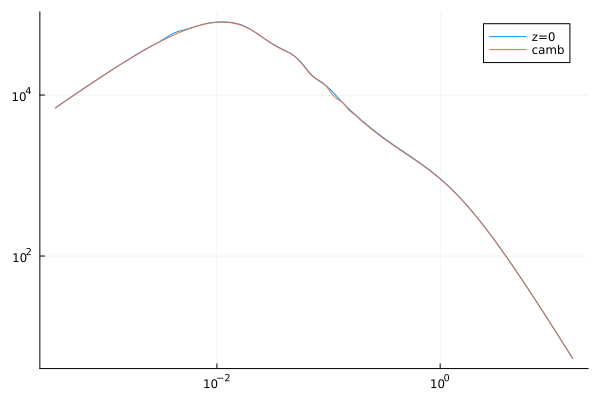

In [57]:
#ks = exp.(LimberJack.emulator.training_karr)
kmax = 200/13 
kmin = 2.5/7000
ks = exp.(LinRange(log(kmin), log(kmax), 1000))
pk_emul_z0 = nonlin_Pk(cosmo_emul_nonlin, ks, 0)
pk_emul_z35 = nonlin_Pk(cosmo_emul_nonlin, ks, 3.5)
plot(ks, pk_emul_z0, xscale=:log10, yscale=:log10, label="z=0")
plot!(k_camb, pk_nl_camb[1,:], label = "camb")

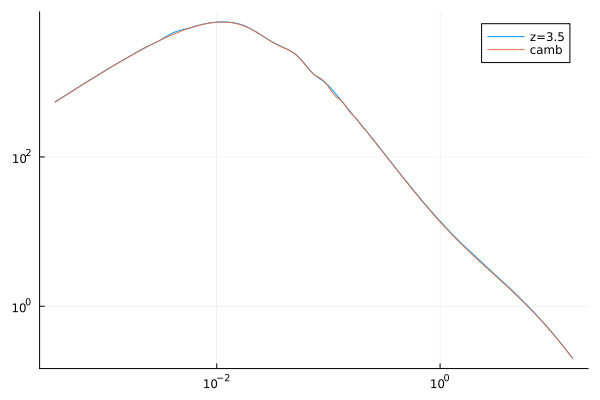

In [58]:
plot(ks, pk_emul_z35, xscale=:log10, yscale=:log10, label="z=3.5")
plot!(k_camb, pk_nl_camb[end,:], label = "camb")

In [60]:
pinterp = AkimaInterpolation(pk_nl_camb[end,:], k_camb, extrapolate=true);

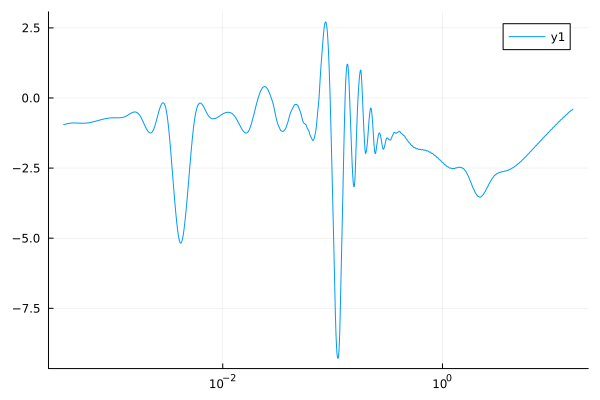

In [62]:
plot(ks, 100 .*(1 .- pk_emul_z35./(pinterp.(ks))), xscale=:log10)